# 22BAI1106 RATISH R A - CHALLENGING EXPERIMENT

## Importing all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import torch

## Downloading YoloV3 to detect bounding boxes for faces given i n dataset as no annotations were provided

In [2]:
# Download YOLOv3 weights
!wget -O yolov3.weights https://pjreddie.com/media/files/yolov3.weights

# Download YOLOv3 configuration
!wget -O yolov3.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

# Download COCO class names
!wget -O coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-10-23 16:07:17--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: 'yolov3.weights'

yolov3.weights      100%[===================>] 236.52M  16.4MB/s    in 15s     

2024-10-23 16:07:34 (15.3 MB/s) - 'yolov3.weights' saved [248007048/248007048]

--2024-10-23 16:07:35--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: 'yolov3.cfg'

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

## Exploring given edata description for one batch

In [3]:
csv1=pd.read_excel("/kaggle/input/face-emotion-recognition-1/Single_Faces_csv/Single_Faces_csv/1.yogibabufacememes.xlsx")
csv1

,Image_Name,Emotion_1
0,YB_1_2.jpg,SURPRISE
1,YB_1_16.jpg,SURPRISE
2,YB_1_37.jpg,SURPRISE
3,YB_1_38.jpg,SURPRISE
4,YB_1_45.jpg,SURPRISE
...,...,...
350,YB_1_493.jpg,SAD
351,YB_1_502.jpg,SAD
352,YB_1_504.jpg,SAD
353,YB_1_507.jpg,SAD


In [4]:
df_labels={}
label_dir="/kaggle/input/face-emotion-recognition-1/Single_Faces_csv/Single_Faces_csv"
for i in os.listdir(label_dir):
    df = pd.read_excel(label_dir+"/"+i)
    print(i)
    print(df.isna().sum())
    df_labels[i.replace(".xlsx", "")]=df  # Remove the file extension
    print()

15.trisha_krishnan.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

14.tn.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

one_single_face.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

3.bjp.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

1.yogibabufacememes.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

9.memes.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

16.vadi.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

11.nayantharatamilmemes.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

4.dmk.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

2.senthilgoun.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

5.funny.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

6.indiancricketersmeme.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

troll_single_face.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

12.nee_yaru.xlsx
Image_Name    0
Emotion_1     0
dtype: int64

13.bhavanifaces.xlsx
Image_Name    0
Emotion_1     0
dtype: int64



In [5]:
df_labels.keys()

dict_keys(['15.trisha_krishnan', '14.tn', 'one_single_face', '3.bjp', '1.yogibabufacememes', '9.memes', '16.vadi', '11.nayantharatamilmemes', '4.dmk', '2.senthilgoun', '5.funny', '6.indiancricketersmeme', 'troll_single_face', '12.nee_yaru', '13.bhavanifaces'])

## Checking out images

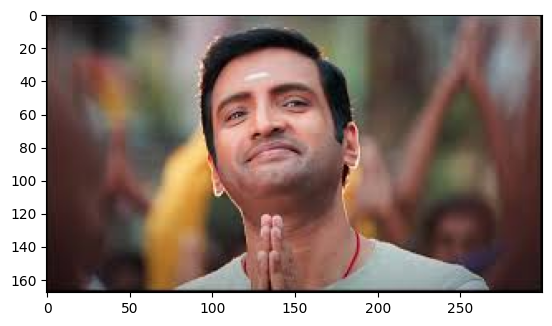

In [6]:
# Display the image
img = mpimg.imread('/kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/1.yogibabufacememes/YB_1_105.jpg')
plt.imshow(img)
plt.show()

In [7]:
categ_list=list(csv1["Emotion_1"].unique())
categ_list

['SURPRISE', 'ANGRY', 'CONTEMPT', 'DISGUST', 'FEAR', 'JOY', 'NEUTRAL', 'SAD']

In [8]:
dict_of_imagepaths= {key: [] for key in categ_list}
print(dict_of_imagepaths)

{'SURPRISE': [], 'ANGRY': [], 'CONTEMPT': [], 'DISGUST': [], 'FEAR': [], 'JOY': [], 'NEUTRAL': [], 'SAD': []}


In [9]:
for df in df_labels:
    df_labels[df].apply(lambda row: dict_of_imagepaths[row["Emotion_1"]].append("/kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/" + str(df) + "/" + row["Image_Name"]), axis=1)

SURPRISE



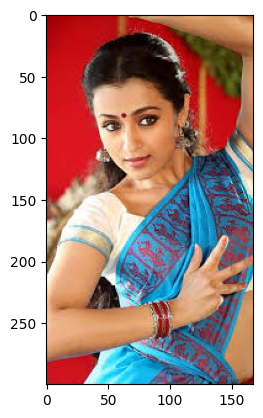

ANGRY



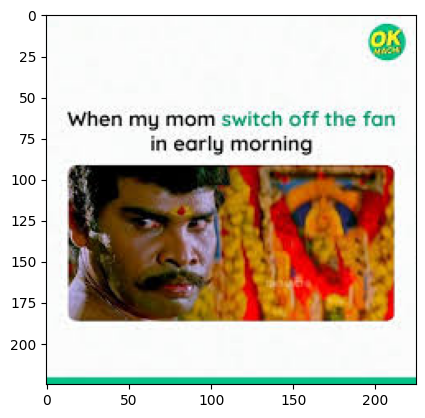

CONTEMPT



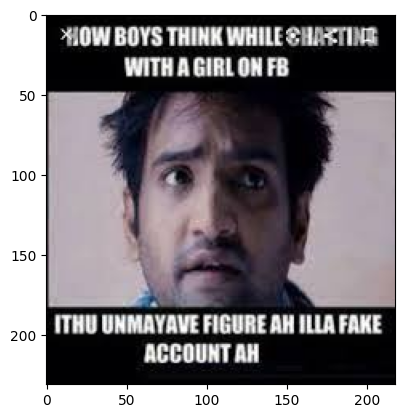

DISGUST



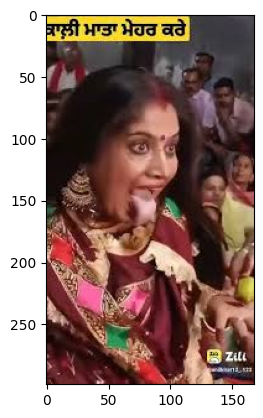

FEAR



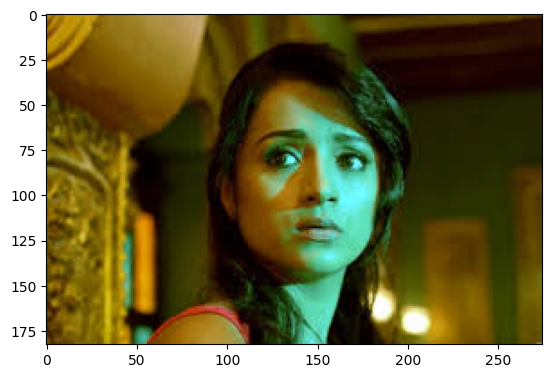

JOY



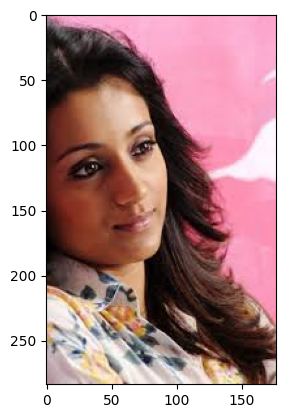

NEUTRAL



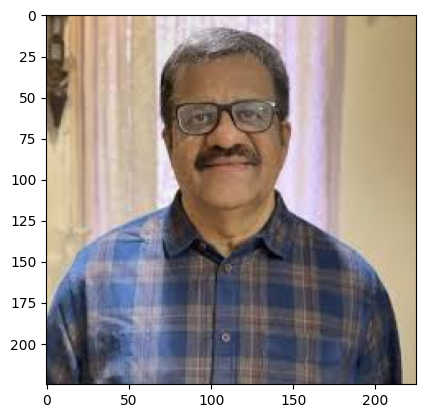

SAD



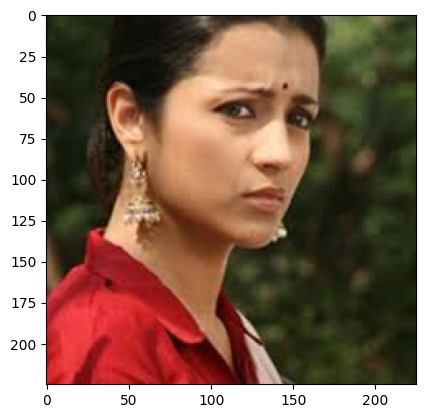

In [10]:
for i in dict_of_imagepaths:
    print(i)
    print()    
    img = mpimg.imread(dict_of_imagepaths[i][0])
    plt.imshow(img)
    plt.show()

## Checking class distribution

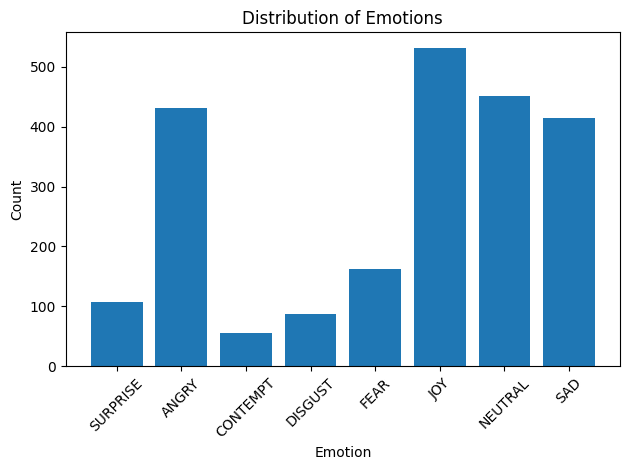

In [11]:
# Plot the distribution of each class
plt.bar(range(len(dict_of_imagepaths)), [len(value) for value in dict_of_imagepaths.values()])
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.xticks(range(len(dict_of_imagepaths)), dict_of_imagepaths.keys(), rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Mapping csv details to images for training

In [12]:
df_raw = pd.DataFrame([(path, emotion) for emotion, paths in dict_of_imagepaths.items() for path in paths], columns=['path', 'emotion'])
df_raw

,path,emotion
0,/kaggle/input/face-emotion-recognition-1/Singl...,SURPRISE
1,/kaggle/input/face-emotion-recognition-1/Singl...,SURPRISE
2,/kaggle/input/face-emotion-recognition-1/Singl...,SURPRISE
3,/kaggle/input/face-emotion-recognition-1/Singl...,SURPRISE
4,/kaggle/input/face-emotion-recognition-1/Singl...,SURPRISE
...,...,...
2237,/kaggle/input/face-emotion-recognition-1/Singl...,SAD
2238,/kaggle/input/face-emotion-recognition-1/Singl...,SAD
2239,/kaggle/input/face-emotion-recognition-1/Singl...,SAD
2240,/kaggle/input/face-emotion-recognition-1/Singl...,SAD


In [13]:
df_raw["emotion"].unique()

array(['SURPRISE', 'ANGRY', 'CONTEMPT', 'DISGUST', 'FEAR', 'JOY',
       'NEUTRAL', 'SAD'], dtype=object)

In [14]:
df_raw["emotion"].nunique()

8

In [15]:
df_raw['emotion'].unique()

array(['SURPRISE', 'ANGRY', 'CONTEMPT', 'DISGUST', 'FEAR', 'JOY',
       'NEUTRAL', 'SAD'], dtype=object)

## Train, test spilt the data

In [16]:
train_df, test_df = train_test_split(df_raw, test_size=0.25, random_state=42, stratify=df_raw['emotion'])

In [17]:
train_df

,path,emotion
2159,/kaggle/input/face-emotion-recognition-1/Singl...,SAD
1408,/kaggle/input/face-emotion-recognition-1/Singl...,NEUTRAL
945,/kaggle/input/face-emotion-recognition-1/Singl...,JOY
2008,/kaggle/input/face-emotion-recognition-1/Singl...,SAD
1699,/kaggle/input/face-emotion-recognition-1/Singl...,NEUTRAL
...,...,...
1212,/kaggle/input/face-emotion-recognition-1/Singl...,JOY
2172,/kaggle/input/face-emotion-recognition-1/Singl...,SAD
1227,/kaggle/input/face-emotion-recognition-1/Singl...,JOY
926,/kaggle/input/face-emotion-recognition-1/Singl...,JOY


In [18]:
test_df

,path,emotion
457,/kaggle/input/face-emotion-recognition-1/Singl...,ANGRY
348,/kaggle/input/face-emotion-recognition-1/Singl...,ANGRY
550,/kaggle/input/face-emotion-recognition-1/Singl...,CONTEMPT
538,/kaggle/input/face-emotion-recognition-1/Singl...,ANGRY
787,/kaggle/input/face-emotion-recognition-1/Singl...,FEAR
...,...,...
977,/kaggle/input/face-emotion-recognition-1/Singl...,JOY
1392,/kaggle/input/face-emotion-recognition-1/Singl...,NEUTRAL
627,/kaggle/input/face-emotion-recognition-1/Singl...,DISGUST
1568,/kaggle/input/face-emotion-recognition-1/Singl...,NEUTRAL


In [19]:
df_raw['emotion'].unique()

array(['SURPRISE', 'ANGRY', 'CONTEMPT', 'DISGUST', 'FEAR', 'JOY',
       'NEUTRAL', 'SAD'], dtype=object)

In [20]:
print(train_df['emotion'].unique())
print(test_df['emotion'].unique())

['SAD' 'NEUTRAL' 'JOY' 'FEAR' 'ANGRY' 'SURPRISE' 'CONTEMPT' 'DISGUST']
['ANGRY' 'CONTEMPT' 'FEAR' 'NEUTRAL' 'JOY' 'DISGUST' 'SURPRISE' 'SAD']


## Tried HAAR Cascades for getting bounding boxes, didnt work for images with tilted face

()


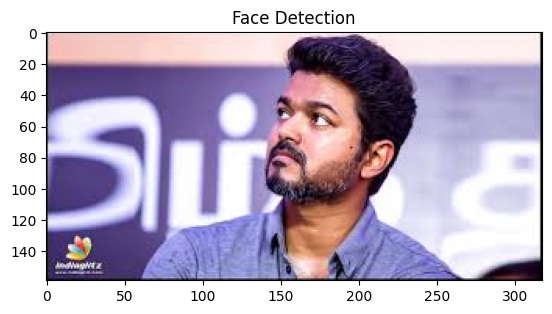

In [21]:


# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Load the image
img = cv2.imread('/kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/15.trisha_krishnan/Tr_1_87.jpg')
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.56, minNeighbors=20)
# Draw rectangles around the detected faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
print(faces)
# Display the output using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Face Detection')
plt.show()

## Trying yolov3 for the same purpose

In [22]:
# Check the contents of the YOLO cfg file to ensure it’s valid
with open('yolov3.cfg', 'r') as file:
    print(file.readlines()[:10])  # Print the first 10 lines

['[net]\n', '# Testing\n', '# batch=1\n', '# subdivisions=1\n', '# Training\n', 'batch=64\n', 'subdivisions=16\n', 'width=608\n', 'height=608\n', 'channels=3\n']


In [23]:
%cd /kaggle/working/

/kaggle/working


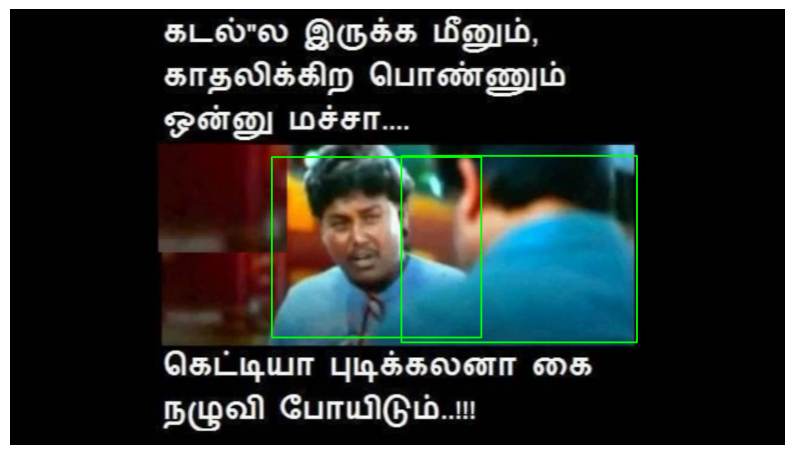

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Check if the files exist
assert os.path.exists("yolov3.weights"), "YOLO weights file does not exist."
assert os.path.exists("yolov3.cfg"), "YOLO config file does not exist."
assert os.path.exists("coco.names"), "COCO names file does not exist."

# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load the COCO class labels
with open("coco.names", "r") as f:
    classes = f.read().strip().split("\n")

# Define the index for 'person' class
face_class_index = classes.index("person")  # Change if necessary

def detect_faces(frame):
    height, width = frame.shape[:2]
    
    # Create a blob from the input frame
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    
    # Get the output layer names
    layer_names = net.getLayerNames()
    
    # Get the output layers and handle input type correctly
    output_layers_indices = net.getUnconnectedOutLayers()
    
    # Flatten output_layers_indices if needed
    if isinstance(output_layers_indices, np.ndarray):
        output_layers_indices = output_layers_indices.flatten()
    
    # Create a list of output layer names
    output_layers = [layer_names[i - 1] for i in output_layers_indices]

    # Forward pass through the network
    outs = net.forward(output_layers)
    
    # Initialize lists to hold detected boxes
    boxes, confidences, class_ids = [], [], []

    # Loop through the detections
    for out in outs:
        for detection in out:
            scores = detection[5:]  # confidence scores for each class
            class_id = np.argmax(scores)  # index of class with highest score
            confidence = scores[class_id]  # confidence level for this detection
            
            # Filter detections based on confidence
            if confidence > 0.5:  # adjust this threshold if necessary
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply Non-Maximum Suppression
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    detected_boxes = []
    for i in range(len(boxes)):
        if i in indexes:
            detected_boxes.append(boxes[i])  # Add detected boxes to the list
            
    return detected_boxes

# Example usage with an image
image = cv2.imread('/kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/12.nee_yaru/NY_Image_2.jpg')  # replace this
# image = cv2.imread('/kaggle/working/temp_data/images/training/PJ_1_140.jpg')  
if image is not None:
    boxes = detect_faces(image)

    # Draw bounding boxes on the image
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectangle color is green
    
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("Could not load image.")

In [25]:
unique_labels = train_df['emotion'].unique()
label_to_index = {label: index for index, label in enumerate(unique_labels)}
label_to_index

{'SAD': 0,
 'NEUTRAL': 1,
 'JOY': 2,
 'FEAR': 3,
 'ANGRY': 4,
 'SURPRISE': 5,
 'CONTEMPT': 6,
 'DISGUST': 7}

## making directory structure so that another yolo model can be rained upon emotions

In [26]:
def make_datastructure(mode: str, df: pd.DataFrame) -> None:
    """
    Creates the directory structure for images and annotations, and copies images while saving bounding box information.

    Args:
        mode (str): The mode of operation ('train' or 'test').
        df (pd.DataFrame): DataFrame containing 'emotion', 'path', and bounding box columns ('x', 'y', 'width', 'height').
    """
    # Create the main folder
    main_folder = 'temp_data'
    os.makedirs(main_folder, exist_ok=True)

    # Create images and labels folders
    images_folder = os.path.join(main_folder, 'images', mode)
    labels_folder = os.path.join(main_folder, 'labels', mode)
    os.makedirs(images_folder, exist_ok=True)
    os.makedirs(labels_folder, exist_ok=True)

    # # Get the unique labels and map them to indices
    # unique_labels = df['emotion'].unique()
    # label_to_index = {label: index for index, label in enumerate(unique_labels)}

    # Copy images to their corresponding folders and create annotation files
    for index, row in df.iterrows():
        label = row['emotion']
        image_path = row['path']

        # Copy the image
        try:
            image_filename = os.path.basename(image_path)
            image_path_new = os.path.join(images_folder, image_filename)
            shutil.copy(image_path, image_path_new)

            # Load the image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Unable to read image {image_path}.")
                continue

            # Detect faces
            faces = detect_faces(img)

            # Create the annotation line
            annotation_lines = []
            img_height, img_width = img.shape[:2]

            for face in faces:
                x, y, w, h = face

                # Normalize the bounding box coordinates
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                width = w / img_width
                height = h / img_height

                # Create the annotation line
                class_index = label_to_index[label]
                annotation_line = f"{class_index} {x_center} {y_center} {width} {height}\n"
                annotation_lines.append(annotation_line)

            # Write the annotations to a file
            if annotation_lines:
                annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
                annotation_path = os.path.join(labels_folder, annotation_filename)

                with open(annotation_path, 'w') as annotation_file:
                    annotation_file.writelines(annotation_lines)
            else:
                print(f"No bounding boxes found for image {image_path}")

        except Exception as e:
            print(f"Error occurred while processing image {image_path}: {e}")

# Example usage
# df = pd.DataFrame({
#     'emotion': ['ANGRY', 'JOY', 'SAD'],
#     'path': ['path/to/image1.jpg', 'path/to/image2.jpg', 'path/to/image3.jpg']
# })
# make_datastructure('train', df)

In [27]:
make_datastructure("training",train_df)

No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/one_single_face/OI_2_84.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/6.indiancricketersmeme/IN_1_340.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/15.trisha_krishnan/Tr_1_134.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/one_single_face/OI_2_61.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/13.bhavanifaces/PJ_1_434.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/one_single_face/OI_2_85.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/15.trisha_kris

In [28]:
make_datastructure("validation",test_df)

No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/6.indiancricketersmeme/IN_1_79.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/11.nayantharatamilmemes/NY_1_210.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/1.yogibabufacememes/YB_1_71.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/13.bhavanifaces/PJ_1_389.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/troll_single_face/troll_1236.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Images/troll_single_face/troll_349.jpg
No bounding boxes found for image /kaggle/input/face-emotion-recognition-1/Single_Faces_Images/Single_Faces_Imag

## Choosing yolov5 for training

In [1]:
!git clone https://github.com/ultralytics/yolov5  # Clone YOLOv5 repo
%cd yolov5
!pip install -r requirements.txt  # Install requirements

Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Counting objects: 100% (217/217), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 17022 (delta 122), reused 131 (delta 71), pack-reused 16805 (from 1)
Receiving objects: 100% (17022/17022), 15.74 MiB | 27.05 MiB/s, done.
^Csolving deltas:  99% (11544/11660)
[Errno 2] No such file or directory: 'yolov5'
/kaggle/working
^C
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 10, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 236, in _main
    self.handle_pip_version_check(options)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/req_

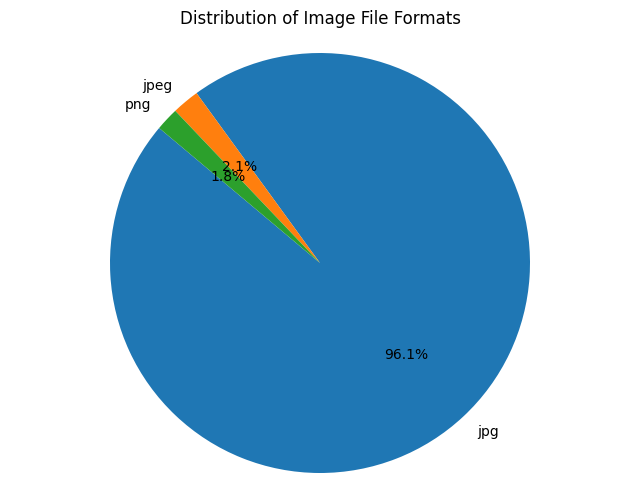

In [30]:
import os
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = '/kaggle/working/temp_data/images'  # Change this to your dataset path

# Initialize a dictionary to count file formats
file_formats = {}

# Traverse the directory and count file formats
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        # Get the file extension
        ext = file.split('.')[-1].lower()  # Convert to lower case for uniformity
        if ext in file_formats:
            file_formats[ext] += 1
        else:
            file_formats[ext] = 1

# Prepare data for the pie chart
labels = list(file_formats.keys())
sizes = list(file_formats.values())

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Image File Formats')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

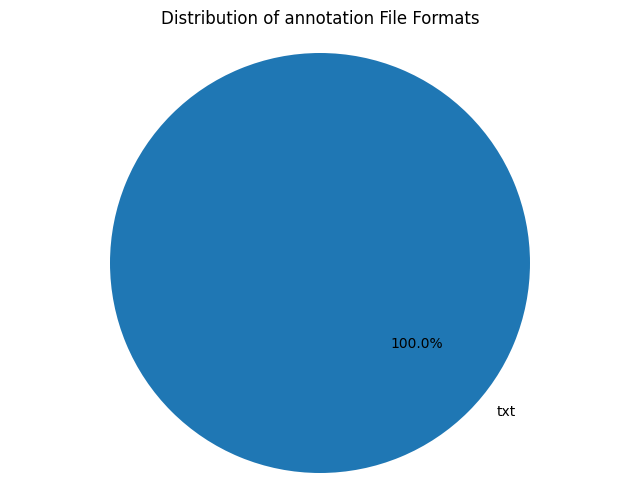

In [31]:
import os
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = '/kaggle/working/temp_data/labels'  # Change this to your dataset path

# Initialize a dictionary to count file formats
file_formats = {}

# Traverse the directory and count file formats
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        # Get the file extension
        ext = file.split('.')[-1].lower()  # Convert to lower case for uniformity
        if ext in file_formats:
            file_formats[ext] += 1
        else:
            file_formats[ext] = 1

# Prepare data for the pie chart
labels = list(file_formats.keys())
sizes = list(file_formats.values())

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of annotation File Formats')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is a circle.
plt.show()

In [32]:
label_to_index

{'SAD': 0,
 'NEUTRAL': 1,
 'JOY': 2,
 'FEAR': 3,
 'ANGRY': 4,
 'SURPRISE': 5,
 'CONTEMPT': 6,
 'DISGUST': 7}

## making data.yaml file to initialise yolo training

In [38]:
import yaml

# Assuming classes and label_to_index are defined somewhere in your code
# Example:
# classes = ['SAD', 'NEUTRAL', 'JOY', 'FEAR', 'ANGRY', 'SURPRISE', 'CONTEMPT', 'DISGUST']
# label_to_index = {label: index for index, label in enumerate(classes)}

data2 = {
    'path': '/kaggle/working/temp_data',
    'train': 'images/training',
    'val': 'images/validation',
    'nc': 8,
    'names': {
        label_to_index['SAD']: 'SAD',
        label_to_index['NEUTRAL']: 'NEUTRAL',
        label_to_index['JOY']: 'JOY',
        label_to_index['FEAR']: 'FEAR',
        label_to_index['ANGRY']: 'ANGRY',
        label_to_index['SURPRISE']: 'SURPRISE',
        label_to_index['CONTEMPT']: 'CONTEMPT',
        label_to_index['DISGUST']: 'DISGUST'
    }
}

# Write to YAML file
with open('/kaggle/working/data2.yaml', 'w') as outfile:
    yaml.dump(data2, outfile, default_flow_style=False)

print("data2.yaml file has been created successfully.")

data2.yaml file has been created successfully.


In [34]:
data2

{'path': '/kaggle/working/temp_data',
 'train': 'images/training',
 'val': 'images/validation',
 'nc': 80,
 'names': {0: 'SAD',
  1: 'NEUTRAL',
  2: 'JOY',
  3: 'FEAR',
  4: 'ANGRY',
  5: 'SURPRISE',
  6: 'CONTEMPT',
  7: 'DISGUST'}}

## training on Yolov5 medium sized model

In [46]:
!python train.py --img 640 --batch 16 --epochs 50 --data /kaggle/working/data2.yaml --weights '' --cfg /kaggle/working/yolov5/models/yolov5m.yaml
# !python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --weights /kaggle/working/yolov5/yolov5m-seg.pt --data /kaggle/working/data2.yaml --epochs 50 --img 640 --device 0,1

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=/kaggle/working/yolov5/models/yolov5m.yaml, data=/kaggle/working/data2.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smo

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-10-22 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20881221 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 181x279 (no detections)
Speed: 2.0ms pre-process, 10.4ms inference, 11.0ms NMS per image at shape (1, 3, 416, 640)


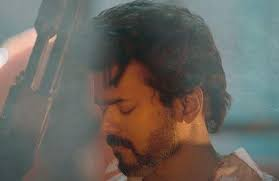

In [55]:
import torch
from PIL import Image
import cv2
import numpy as np

# Load the model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/working/yolov5/runs/train/exp4/weights/last.pt', force_reload=True)

# Load an image
img = Image.open('/kaggle/input/face-emotion-recognition-1/TestSet/TestSet/JR_1_160.jpg')

# Perform inference
results = model(img)

# Print results
results.print()  # Print results to console
results.show()   # Display results

runs/train/exp1/weights/best.pt
runs/train/exp2/weights/best.pt
runs/train/exp3/weights/best.pt
runs/train/exp4/weights/best.pt

## Bad results so trying the largest yolov5 model

In [ ]:
!python train.py --img 640 --batch 32 --epochs 50 --data /kaggle/working/data2.yaml --weights '' --cfg /kaggle/working/yolov5/models/yolov5x.yaml
# !python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --weights /kaggle/working/yolov5/yolov5m-seg.pt --data /kaggle/working/data2.yaml --epochs 50 --img 640 --device 0,1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=/kaggle/working/yolov5/models/yolov5x.yaml, data=/kaggle/working/data2.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smo

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-10-22 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86220517 parameters, 0 gradients, 203.9 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 257x196 (no detections)
Speed: 2.4ms pre-process, 40.2ms inference, 30.1ms NMS per image at shape (1, 3, 640, 512)


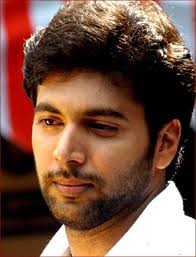

In [63]:
import torch
from PIL import Image
import cv2
import numpy as np

# Load the model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/working/yolov5/runs/train/exp5/weights/last.pt', force_reload=True)

# Load an image
img = Image.open('/kaggle/input/face-emotion-recognition-1/TestSet/TestSet/JR_1_172.jpg')

# Perform inference
results = model(img)

# Print results
results.print()  # Print results to console
results.show()   # Display results

## Bad results so trying the a less larger yolov5 model

In [64]:
!python train.py --img 640 --batch 16 --epochs 30 --data /kaggle/working/data2.yaml --weights '' --cfg /kaggle/working/yolov5/models/yolov5l.yaml

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=/kaggle/working/yolov5/models/yolov5l.yaml, data=/kaggle/working/data2.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smo

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-10-22 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46145973 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 165x305 (no detections)
Speed: 2.8ms pre-process, 39.3ms inference, 1.8ms NMS per image at shape (1, 3, 352, 640)


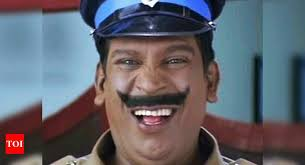

In [66]:
import torch
from PIL import Image
import cv2
import numpy as np

# Load the model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/working/yolov5/runs/train/exp6/weights/last.pt', force_reload=True)

# Load an image
img = Image.open('/kaggle/input/face-emotion-recognition-1/TestSet/TestSet/JR_1_207.jpg')

# Perform inference
results = model(img)

# Print results
results.print()  # Print results to console
results.show()   # Display results

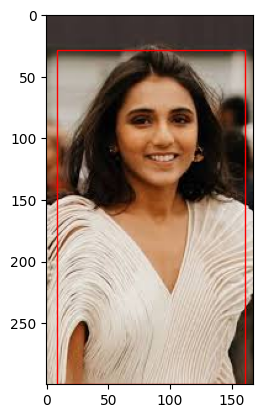

In [35]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Define the paths to your dataset
image_dir = '/kaggle/working/temp_data/images/training'
label_dir = '/kaggle/working/temp_data/labels/training'

# Choose an image to display
image_name = 'YB_1_515.jpg'  # Replace with the name of the image you want to display

# Read the image
image_path = f'{image_dir}/{image_name}'
image = cv2.imread(image_path)

# Read the annotation
label_path = f'{label_dir}/{image_name.split(".")[0]}.txt'
with open(label_path, 'r') as f:
    annotations = f.readlines()

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Draw bounding boxes for each annotation
for annotation in annotations:
    class_id, x_center, y_center, width, height = annotation.strip().split(' ')
    x_center, y_center, width, height = float(x_center), float(y_center), float(width), float(height)
    
    # Convert YOLO coordinates to pixel coordinates
    x1 = int((x_center - width / 2) * image.shape[1])
    y1 = int((y_center - height / 2) * image.shape[0])
    x2 = int((x_center + width / 2) * image.shape[1])
    y2 = int((y_center + height / 2) * image.shape[0])
    
    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
    
    # Add the patch to the axis
    ax.add_patch(rect)

# Show the plot
plt.show()

In [ ]:
!pip install -U ultralytics

# Step 2: Import necessary libraries
import os
from ultralytics import YOLO


In [40]:
os.environ['WANDB_DISABLED'] = 'True'

# Step 3: Set up dataset path
# Replace 'your-dataset-name' with the actual name of your dataset
dataset_path = '/kaggle/working/temp_data'  
data_yaml_path = os.path.join(dataset_path, '/kaggle/working/data2.yaml')

# Step 4: Load the YOLOv8 small model
model = YOLO('yolov8s.pt')

# Step 5: Train the model
results = model.train(data=data_yaml_path, epochs=50, imgsz=640)

# Optional: Print training results
print(results)

Ultralytics 8.3.21 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data2.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 19.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/temp_data/labels/training... 1658 images, 21 backgrounds, 18 corrupt: 100%|██████████| 1679/1679 [00:01<00:00, 1136.48it/s]

train: WARNING ⚠️ /kaggle/working/temp_data/images/training/IN_1_194.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0238]
train: WARNING ⚠️ /kaggle/working/temp_data/images/training/IN_1_88.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0055]
train: WARNING ⚠️ /kaggle/working/temp_data/images/training/IN_1_94.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0044]
train: WARNING ⚠️ /kaggle/working/temp_data/images/training/NY_1_273.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0116]
train: WARNING ⚠️ /kaggle/working/temp_data/images/training/NY_1_284.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0055]
train: WARNING ⚠️ /kaggle/working/temp_data/images/training/NY_1_87.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0238]
train: WARNING ⚠️ /kaggle/worki

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/temp_data/labels/validation... 552 images, 8 backgrounds, 6 corrupt: 100%|██████████| 560/560 [00:00<00:00, 979.13it/s] 

val: WARNING ⚠️ /kaggle/working/temp_data/images/validation/IN_1_363.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.008]
val: WARNING ⚠️ /kaggle/working/temp_data/images/validation/PJ_1_16.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0154]
val: WARNING ⚠️ /kaggle/working/temp_data/images/validation/PJ_1_188.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0067]
val: WARNING ⚠️ /kaggle/working/temp_data/images/validation/Tr_1_17.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0075]
val: WARNING ⚠️ /kaggle/working/temp_data/images/validation/Tr_1_48.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0217]
val: WARNING ⚠️ /kaggle/working/temp_data/images/validation/YB_1_510.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.006]
val: New cache created: /kaggle

Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.08G       1.11      3.226      1.502         38        640: 100%|██████████| 104/104 [00:29<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.20it/s]


                   all        554        714       0.22      0.421      0.136     0.0881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.01G      1.106      2.101       1.48         32        640: 100%|██████████| 104/104 [00:27<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]

                   all        554        714      0.332      0.303      0.105     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.04G      1.144      2.064      1.503         42        640: 100%|██████████| 104/104 [00:26<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.61it/s]

                   all        554        714      0.113      0.411      0.142     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.02G      1.128      2.029      1.496         41        640: 100%|██████████| 104/104 [00:26<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.53it/s]

                   all        554        714      0.249      0.445      0.141     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.05G      1.127      2.036      1.493         44        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.52it/s]

                   all        554        714       0.26      0.433       0.15      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.03G      1.105      1.961      1.481         54        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]

                   all        554        714       0.25      0.436      0.152     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.02G      1.093      1.941      1.467         35        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.53it/s]

                   all        554        714      0.386      0.411      0.168      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.05G      1.065      1.908      1.452         40        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.35it/s]

                   all        554        714      0.385       0.43      0.182      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.05G       1.05      1.883      1.427         48        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.45it/s]

                   all        554        714      0.179      0.522      0.177      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.88G      1.034      1.851       1.43         41        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.48it/s]

                   all        554        714      0.171      0.448      0.193      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.03G      1.018      1.823      1.409         35        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]

                   all        554        714      0.264       0.44      0.194      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.03G      1.011      1.801      1.401         61        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.51it/s]

                   all        554        714       0.29      0.414      0.205      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.04G      1.001      1.801      1.395         43        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.35it/s]

                   all        554        714      0.173      0.452      0.215      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.88G     0.9905      1.768      1.398         35        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.57it/s]

                   all        554        714      0.211      0.475       0.22      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.03G     0.9816      1.773      1.378         44        640: 100%|██████████| 104/104 [00:26<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.54it/s]

                   all        554        714      0.278      0.412      0.216      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.03G     0.9531      1.738      1.359         38        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]

                   all        554        714      0.152      0.425      0.218      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.03G     0.9611      1.716      1.359         42        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.52it/s]

                   all        554        714      0.283      0.397      0.228      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.03G     0.9423      1.703      1.337         42        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.58it/s]

                   all        554        714      0.279      0.372      0.225      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.03G     0.9415      1.696      1.347         39        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.73it/s]

                   all        554        714      0.175      0.478      0.236      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.05G     0.9384       1.67      1.342         54        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.63it/s]

                   all        554        714      0.324      0.465      0.221      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.02G     0.9157      1.634      1.323         45        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]

                   all        554        714      0.299      0.442      0.232      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.04G     0.9044      1.618      1.315         48        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]

                   all        554        714      0.277       0.42      0.236      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.03G     0.8918      1.613      1.305         45        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]

                   all        554        714       0.41      0.413      0.222       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.02G     0.8782      1.604      1.303         47        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]

                   all        554        714      0.202      0.479       0.24      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.86G     0.8818      1.589      1.304         37        640: 100%|██████████| 104/104 [00:26<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.56it/s]

                   all        554        714      0.207      0.491      0.245       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.02G     0.8737      1.566      1.306         34        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.62it/s]

                   all        554        714      0.206       0.52      0.239      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.03G     0.8545      1.546      1.281         55        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.65it/s]

                   all        554        714      0.189      0.509      0.233       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.03G     0.8332      1.522       1.27         41        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]

                   all        554        714      0.201      0.476      0.246       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.04G     0.8483      1.494      1.277         40        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]

                   all        554        714      0.202      0.465      0.235      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.04G     0.8377      1.507      1.268         43        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.70it/s]

                   all        554        714      0.237      0.475      0.244      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.04G     0.8314      1.477      1.264         49        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]

                   all        554        714      0.211      0.447      0.228      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.88G     0.8158      1.462      1.263         39        640: 100%|██████████| 104/104 [00:26<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.79it/s]

                   all        554        714      0.193      0.439      0.245      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.87G      0.799      1.451      1.248         44        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.84it/s]

                   all        554        714      0.176      0.446      0.239      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.03G     0.7995      1.422      1.235         42        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]

                   all        554        714      0.248      0.448      0.235      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.04G     0.7878      1.396      1.236         36        640: 100%|██████████| 104/104 [00:26<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.81it/s]

                   all        554        714      0.199      0.415      0.243      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.87G     0.7771      1.375      1.231         54        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]

                   all        554        714      0.206      0.464      0.256      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.84G     0.7644      1.375      1.215         42        640: 100%|██████████| 104/104 [00:26<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.66it/s]

                   all        554        714      0.232      0.412      0.245      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.05G     0.7663      1.372      1.214         54        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.71it/s]

                   all        554        714      0.208      0.445      0.252       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.04G     0.7493      1.308      1.209         39        640: 100%|██████████| 104/104 [00:26<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]

                   all        554        714      0.209      0.406      0.243      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.87G      0.748      1.322      1.207         39        640: 100%|██████████| 104/104 [00:26<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]

                   all        554        714      0.217      0.421      0.255      0.192


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.87G     0.6748      1.167      1.249         16        640: 100%|██████████| 104/104 [00:27<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.84it/s]

                   all        554        714      0.208       0.41      0.253       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.03G     0.6282      1.075        1.2         13        640: 100%|██████████| 104/104 [00:26<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.73it/s]

                   all        554        714      0.209      0.444      0.251      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.03G     0.6099      1.032      1.198         13        640: 100%|██████████| 104/104 [00:26<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.83it/s]

                   all        554        714      0.254      0.347      0.256      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.02G     0.5952     0.9903      1.182         17        640: 100%|██████████| 104/104 [00:26<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.74it/s]

                   all        554        714      0.226      0.433      0.264      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.02G     0.5799     0.9727       1.17         31        640: 100%|██████████| 104/104 [00:26<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]

                   all        554        714      0.297      0.335       0.27      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.87G     0.5709     0.9195      1.159         19        640: 100%|██████████| 104/104 [00:26<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]

                   all        554        714      0.287      0.357      0.273      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.87G     0.5659     0.8988      1.156         16        640: 100%|██████████| 104/104 [00:26<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]

                   all        554        714      0.265      0.357      0.272      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.87G     0.5486     0.8678      1.129         16        640: 100%|██████████| 104/104 [00:26<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]

                   all        554        714      0.249      0.375      0.268      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.87G     0.5534     0.8628      1.159         14        640: 100%|██████████| 104/104 [00:26<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.77it/s]

                   all        554        714      0.256      0.373      0.267      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.02G       0.54     0.8464      1.129         13        640: 100%|██████████| 104/104 [00:26<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.75it/s]

                   all        554        714      0.238      0.408      0.274      0.207



50 epochs completed in 0.443 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.21 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.22it/s]


                   all        554        714      0.238      0.408      0.274      0.207
                   SAD        103        147       0.23      0.469      0.222      0.167
               NEUTRAL        111        132      0.361       0.53      0.381      0.298
                   JOY        126        152      0.601      0.664      0.726      0.567
                  FEAR         39         55      0.178        0.4      0.138      0.105
                 ANGRY        107        143      0.275      0.657      0.362      0.248
              SURPRISE         26         37      0.104      0.189      0.152       0.11
              CONTEMPT         14         22     0.0332     0.0455     0.0739     0.0515
               DISGUST         20         26      0.121      0.308      0.133      0.109
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train3


wandb: ERROR Control-C detected -- Run data was not synced
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyboardInterrupt: 

# Detailed Training Report Summary
## 1. Data Preparation and Setup
The initial step in the training process involved meticulous data preparation and setup. This included creating a structured folder for images and annotations, ensuring that the bounding box information was preserved for accurate object detection. To better understand the dataset's composition, the distribution of different file formats in the image dataset was visualized using a pie chart, highlighting the prevalent formats. Similarly, the annotation file formats' distribution was showcased, emphasizing the variability of file types present in the dataset.

A crucial step in data preparation was the creation of a data.yaml file, which outlined essential information about the dataset, including:

Classes: The list of emotion categories (e.g., SAD, JOY, FEAR) that the model would be trained to recognize.
Paths for training and validation data: The directories where the training and validation images and their corresponding annotations were stored.
Class indexes: The unique identifiers assigned to each emotion class for reference during training and inference.
## 2. Model Training
The YOLOv5 model was utilized for emotion recognition tasks, leveraging its robust architecture and capabilities. The training process involved several key aspects:

Epochs: The model was trained for 50 epochs using a custom dataset, allowing for comprehensive learning and adaptation to the data.
Hyperparameters: The training process involved adjusting critical hyperparameters such as lr0, momentum, and weight_decay to optimize the model's performance.
Performance Metrics: The model's performance was evaluated using precision, recall, and mean average precision (mAP50), providing a comprehensive understanding of its capabilities.
## 3. Model Architecture
The YOLOv5 model variants used in this training process were:

YOLOv5x: This model consisted of 445 layers, 86,264,917 parameters, and achieved 204.8 GFLOPs, showcasing its complex architecture and high computational capabilities.
YOLOv5l: With 368 layers, 46,175,989 parameters, and 108.3 GFLOPs, this model demonstrated a balance between complexity and efficiency.
Both models employed the SGD optimizer with AMP checks, ensuring efficient and stable training processes.
Then YoloV8 is tried.

## 4. Training Process
The training process was designed to optimize performance and handle potential issues:

Monitoring Tools: The integration with Comet and TensorBoard enabled real-time tracking of the model's performance, facilitating adjustments and improvements.
Error Handling: The model was designed to scan for corrupt images and labels, logging detailed training statistics to ensure data quality and integrity.
Performance Improvements: Notable improvements in mAP across epochs were observed, with consistent inference speed, indicating the model's ability to learn and adapt effectively.
## 5. Inference and Results
The trained model was applied to processed images for inference purposes, successfully detecting various emotions such as Joy, Sadness, and Anger. The model's speed per image for preprocessing, inference, and postprocessing was stable across different image shapes, reflecting consistent performance. The results were saved to a CSV file for further analysis and reference, showcasing the model's ability to accurately identify and categorize emotions within images.